[ 46.  93. 138. 195.]


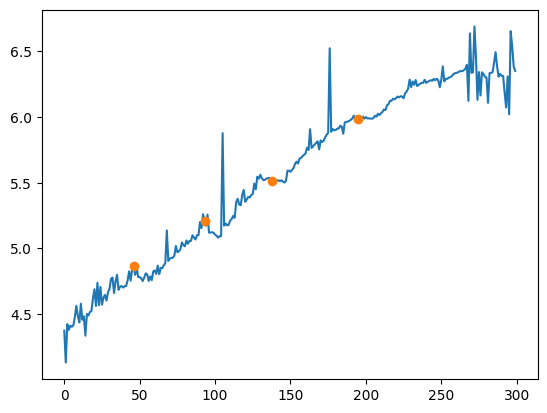

[ 41. 103. 123. 211.]


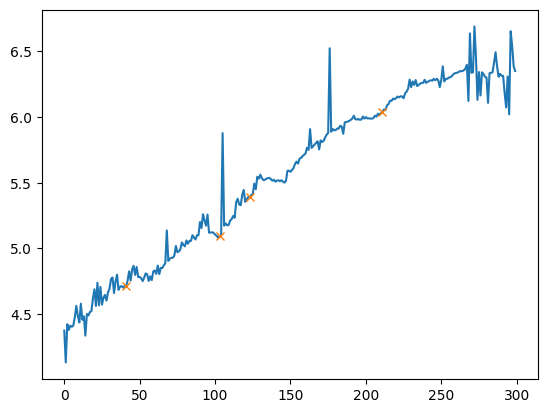

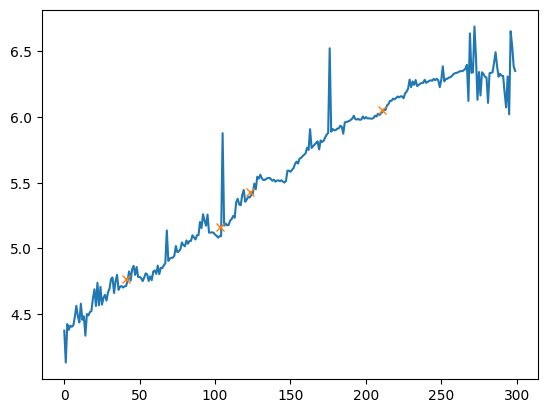

In [27]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter, find_peaks, medfilt
from scipy.ndimage import uniform_filter1d
from scipy.stats import linregress
from numpy.polynomial.polynomial import polyfit


def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def interpolate_nans(signal):
    nans, x= nan_helper(signal)
    signal[nans]= np.interp(x(nans), x(~nans), signal[~nans])
    return signal

def interpolate_peaks(signal):
    try:
        peaks = find_peaks(signal, prominence=0.1, wlen=7, distance=1)[0]
        interpolated_signal = signal.copy()
        interpolated_signal[peaks] = np.nan
        interpolated_signal = interpolate_nans(interpolated_signal)
        return interpolated_signal
    except ValueError:
        return signal

def find_mid_molts(volume, molt_size_range):
    """Find mid-molts in a volume time series."""

    log_moult_size_range = np.log(molt_size_range)
    # Smooth volume time series
    log_volume = np.log(volume)
    log_volume = interpolate_peaks(log_volume)
    medfilt_log_volume = medfilt(log_volume, 3)
    savgol_log_volume = savgol_filter(medfilt_log_volume, 9, 3)

    # Calculate derivative
    log_diff = np.diff(savgol_log_volume)
    # Smooth derivative
    smoothed_log_diff = uniform_filter1d(uniform_filter1d(log_diff, size=25), size = 10)

    # Find peaks in the smoothed derivative
    linear_regression_fit_range = 5
    peaks = find_peaks(-smoothed_log_diff, prominence=1e-5)[0] # type: ignore
    peaks = peaks[peaks > linear_regression_fit_range]

    log_volume_at_peaks = savgol_log_volume[peaks]
    selected_peaks = np.full((4,), np.nan)

    # Find the best peak for each molt
    for i, log_moult_size in enumerate(log_moult_size_range):
        # Find peaks that are close to the expected size
        possible_peaks = peaks[abs(log_volume_at_peaks - log_moult_size) < np.log(1.5)]
        slopes = np.empty((len(possible_peaks),))

        # Find the best one by computing the slope of the linear regression
        if len(possible_peaks) > 0:
            for j, peak in enumerate(possible_peaks):
                fit_range = np.arange(peak - linear_regression_fit_range, peak + linear_regression_fit_range + 1)
                fit_range = fit_range[fit_range > 1]
                fit_range = fit_range[fit_range < len(savgol_log_volume)]

                p = linregress(fit_range[np.isfinite(savgol_log_volume[fit_range])], medfilt_log_volume[fit_range[np.isfinite(savgol_log_volume[fit_range])]])
                slopes[j] = p.slope # type: ignore
            
            # Select the peak with the smallest slope
            best_peak = possible_peaks[np.argmin(slopes)]
            selected_peaks[i] = best_peak

    # Remove peaks that are too close to each other
    for i in range(3, 0, -1):
        if np.isfinite(selected_peaks[i]) and np.isfinite(selected_peaks[i - 1]):
            if selected_peaks[i] - selected_peaks[i - 1] < 6 or selected_peaks[i-1] > selected_peaks[i - 1]:
                selected_peaks[i - 1] = np.nan

    midmoults = selected_peaks
    size_at_mid_moults = np.array([np.exp(medfilt_log_volume[int(midmoult)]) if np.isfinite(midmoult) else np.nan for midmoult in midmoults])

    return midmoults, size_at_mid_moults

def find_end_molts(volume, midmolts, search_width = 20, fit_width = 5):
    # Smooth volume time series
    log_volume = np.log(volume)
    log_volume = interpolate_peaks(log_volume)
    log_volume = -interpolate_peaks(-log_volume)

    medfilt_log_volume = medfilt(log_volume, 3)

    endmolts = np.full((4,), np.nan)
    for i, midmolt in enumerate(midmolts):
        if np.isfinite(midmolt):

            search_window = range(int(max(midmolt - search_width, 0)), int(min(midmolt + search_width + 1, len(medfilt_log_volume))))
            
            slope1 = np.full_like(medfilt_log_volume, np.nan)
            slope2 = np.full_like(medfilt_log_volume, np.nan)

            for h in search_window:

                # split search window into two parts
                fit_range1 = np.arange(max(0, h - fit_width), h+1, dtype=int)
                fit_range2 = np.arange(h, min(h + 1 + fit_width, len(medfilt_log_volume)), dtype=int)
                # fit linear regression to each part
                p1 = linregress(fit_range1[np.isfinite(medfilt_log_volume[fit_range1])], medfilt_log_volume[fit_range1[np.isfinite(medfilt_log_volume[fit_range1])]])
                p2 = linregress(fit_range2[np.isfinite(medfilt_log_volume[fit_range2])], medfilt_log_volume[fit_range2[np.isfinite(medfilt_log_volume[fit_range2])]])

                slope1[h] = p1.slope
                slope2[h] = p2.slope
            second_derivative = slope2 - slope1

            a = np.max(second_derivative[search_window])
            b = np.argmax(second_derivative[search_window])
            # if np.isfinite(a):
            #     fit_range = np.arange(max(b - 4, 0), min(b + 4 + 1, len(medfilt_log_volume)))
            #     p = np.polyfit(fit_range, second_derivative[search_window][fit_range], 3)
            #     b = np.argmax(np.polyval(p, fit_range))
            #     b = fit_range[b]

            endmolts[i] = search_window[b]
    
    return endmolts


moult_size_range = [6.6e4, 15e4, 36e4, 102e4]
log_moult_size_range = np.log(moult_size_range)
moults = np.empty((4,))

# Load the filemap dataframe.
filemap = pd.read_csv('/mnt/external.data/TowbinLab/kstojanovski/20220401_Ti2_20x_160-182-190_pumping_25C_20220401_173300_429/analysis/report/analysis_filemap.csv')

# Plot the volume over time for each point.
point = 11

# Get the volume for each timepoint for the given point.
volume = filemap.loc[filemap['Point'] == point, ['Volume', 'WormType']]['Volume']
worm_type = filemap.loc[filemap['Point'] == point, ['Volume', 'WormType']]['WormType'].values
volume = np.array(volume)

errors = np.where(worm_type == "i")

volume_for_finding_molts = volume.copy()
volume_for_finding_molts[errors] = np.nan

midmoults, size_at_mid_moults = find_mid_molts(volume_for_finding_molts, moult_size_range)
print(midmoults)

plt.plot(np.log10(volume))
plt.plot(midmoults[np.isfinite(midmoults)], np.log10(volume)[midmoults[np.isfinite(midmoults)].astype(int)], 'o')
plt.show()

endmolts = find_end_molts(volume_for_finding_molts, midmoults)
print(endmolts)


plt.plot(np.log10(volume))
plt.plot(endmolts[np.isfinite(endmolts)], np.log10(volume)[endmolts[np.isfinite(endmolts)].astype(int)], 'x')
plt.show()

def find_hatch_time(worm_types):
    worm_index = np.argwhere(worm_types == "worm")
    if worm_index.size == 0:
        return np.nan

    first_worm = worm_index[0][0]
    eggs_before_first_worm = np.argwhere(worm_types[:first_worm] == "egg")

    if eggs_before_first_worm.size == 0:
        return np.nan
    
    last_egg = eggs_before_first_worm[-1][0]

    hatch_time = last_egg + 1
    return hatch_time

def compute_volume_at_ecdysis(volume, worm_types, hatch_time, endmolts, fit_width = 10):
    if np.isfinite(hatch_time):
        fit_x = np.arange(max(0, hatch_time - fit_width), min(len(volume), hatch_time + fit_width), dtype=int)
        filtered_fit_x = fit_x[np.where(worm_types[fit_x] == "worm")]
        if filtered_fit_x.size != 0:
            fit_y = np.log(volume[filtered_fit_x])
            p = np.polyfit(filtered_fit_x, fit_y, 1)
            volume_at_hatch = np.exp(np.polyval(p, hatch_time))
        else:
            volume_at_hatch = np.nan
    else: 
        volume_at_hatch = np.nan
    
    volume_at_molts = np.full_like(endmolts, np.nan)
    for i, molt in enumerate(endmolts):
        if np.isfinite(molt):
            fit_x = np.arange(max(0, molt - fit_width), min(len(volume), molt + fit_width), dtype=int)
            filtered_fit_x = fit_x[np.where(worm_types[fit_x] == "worm")]
            if filtered_fit_x.size != 0:
                fit_y = np.log(volume[filtered_fit_x])
                p = np.polyfit(filtered_fit_x, fit_y, 1)
                volume_at_molt = np.exp(np.polyval(p, molt))
                volume_at_molts[i] = volume_at_molt
            else:
                volume_at_molts[i] = np.nan
        else:
            volume_at_molts[i] = np.nan
    
    return volume_at_hatch, volume_at_molts
    


h, v = compute_volume_at_ecdysis(volume, worm_type, find_hatch_time(worm_type), endmolts)

plt.plot(np.log10(volume))
plt.plot(endmolts[np.isfinite(endmolts)], np.log10(v), 'x')
plt.show()